In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
age_gender = pd.read_csv("age_gender_info.csv")
sample_submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## 데이터확인

### 공지 오류데이터제외

In [3]:
train_error=['C2085', 'C1397','C2431','C1649', 'C1036','C1095', 'C2051', 'C1218', 'C1894','C2483', 'C1502', 'C1988']
test_error=['C2675','C2335', 'C1327']

mask1=train['단지코드'].isin(train_error)
mask2=test['단지코드'].isin(test_error)

# 조건를 충족하지 않는 데이터를 필터링하여 새로운 변수에 저장
train=train[~mask1].reset_index()
test=test[~mask2].reset_index()

### 중복행 제거

In [4]:
train = train.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [5]:
train = train.drop(['index'],axis=1)
test = test.drop(['index'],axis=1)

In [6]:
train.shape

(2869, 15)

In [7]:
test.shape

(1008, 14)

### column명 변경

In [8]:
train.columns=['단지코드','총세대수','임대건물구분','지역','공급유형','전용면적','전용면적별세대수','공가수','자격유형',
           '임대보증금','임대료','지하철역수','버스정류장수','단지내주차면수','등록차량수']
test.columns=['단지코드','총세대수','임대건물구분','지역','공급유형','전용면적','전용면적별세대수','공가수','자격유형',
           '임대보증금','임대료','지하철역수','버스정류장수','단지내주차면수']

### 데이터타입과 결측치확인

In [9]:
train.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
자격유형         object
임대보증금        object
임대료          object
지하철역수       float64
버스정류장수      float64
단지내주차면수     float64
등록차량수       float64
dtype: object

In [10]:
pd.DataFrame(train.isnull().sum())

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,569


---

## 변수분포확인

### 범주형 변수 확인

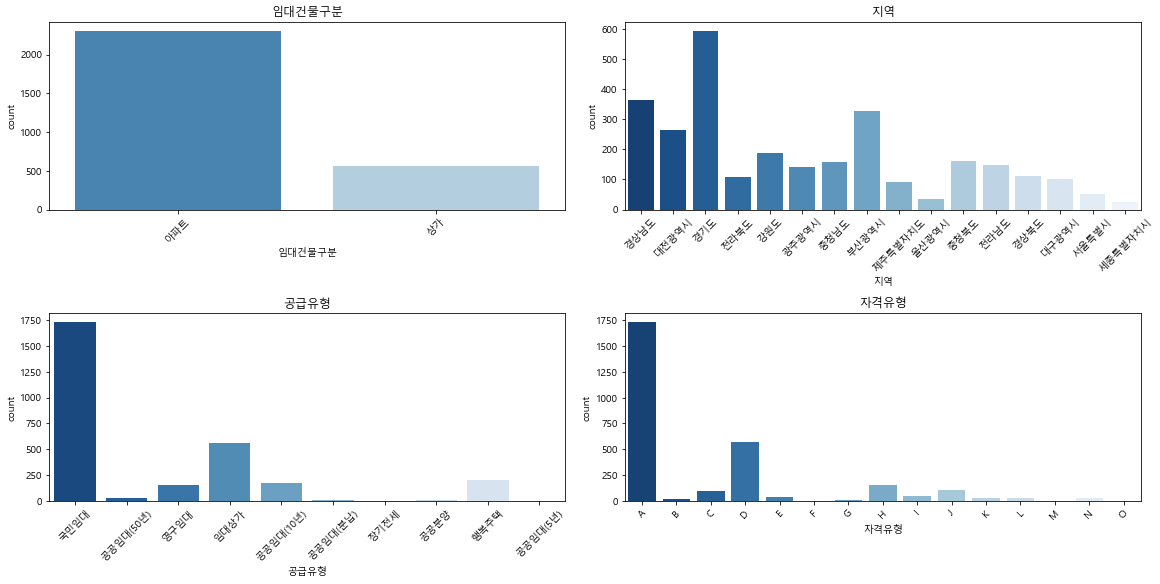

In [11]:
df_ct=['임대건물구분','지역','공급유형','자격유형']
f,ax=plt.subplots(2,2,figsize=(16,8),constrained_layout=True)
j=[0,0,1,1]    # 그래프행설정
k=[0,1,0,1]    # 그래프열설정
for i,j,k in zip(df_ct,j,k):
    sns.countplot(x=i,data=train,ax=ax[j,k],palette='Blues_r')
    ax[j,k].title.set_text(i)
    plt.rc('font',family='Malgun Gothic')
    plt.rc('axes',unicode_minus=False)
    ax[j,k].set_xticklabels(train[i].unique(),rotation=45)

##### 임대건물구분 / 공급유형 / 자격유형이 한 부분으로 쏠려있는 형태

In [12]:
train['단지코드'].value_counts()

C1439    48
C2132    47
C1859    40
C1790    33
C2597    32
         ..
C2651     2
C2340     1
C2520     1
C2437     1
C2188     1
Name: 단지코드, Length: 411, dtype: int64

### 연속형 변수 확인

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


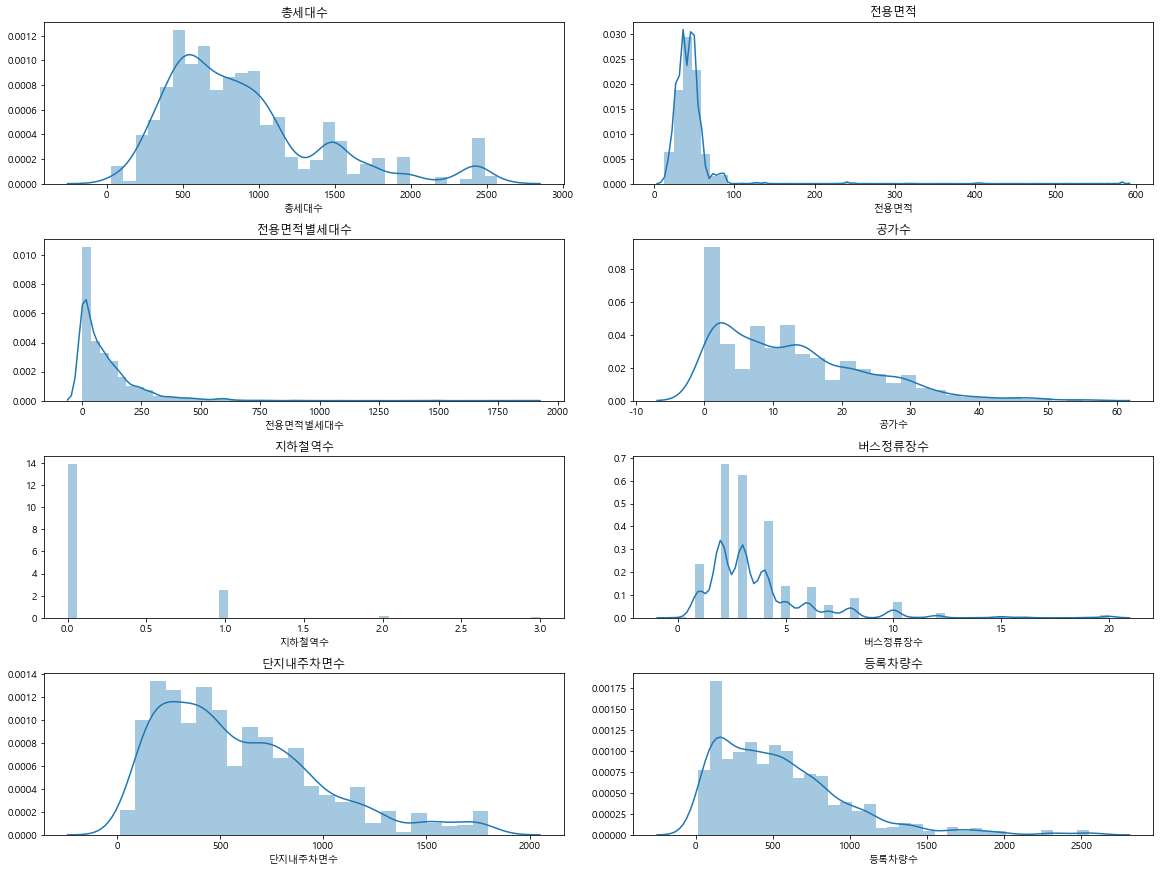

In [13]:
df_num=['총세대수','전용면적','전용면적별세대수','공가수','지하철역수',
        '버스정류장수','단지내주차면수','등록차량수']
f,ax=plt.subplots(4,2,figsize=(16,12),constrained_layout=True)
j=[0,0,1,1,2,2,3,3]
k=[0,1,0,1,0,1,0,1]
for i,j,k in zip(df_num,j,k):
    sns.distplot(train[i],ax=ax[j,k])
    ax[j,k].title.set_text(i)
    plt.rc('font',family='Malgun Gothic')
    plt.rc('axes',unicode_minus=False)

### 변수 생성 (평수)

In [14]:
#84m2미만 : 전용면적*0.3025+9 / 84m2이상 : 전용면적*0.3025+10
train['평수']=np.where(train['전용면적'].values<84, train['전용면적'].values*0.3025+9,train['전용면적'].values*0.3025+10)
train['평수']=round(train['평수'])

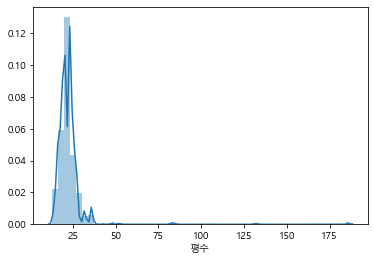

In [15]:
#평수 분포
sns.distplot(train['평수'])
plt.rc('font',family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)

### 자격유형변수 확인

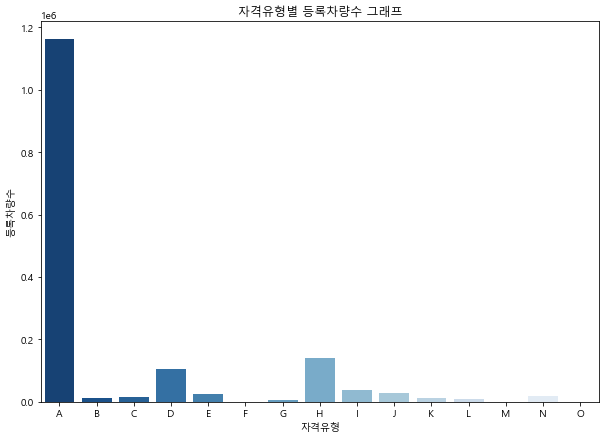

In [16]:
# 1.자격유형에 따른 등록차량수
d1 = train.groupby('자격유형')['등록차량수'].agg(**{'등록차량수':'sum'}).reset_index()

plt.rc('font',family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)
plt.figure(figsize=(10,7))
sns.barplot(x='자격유형',y='등록차량수',data=d1,palette='Blues_r')
plt.title('자격유형별 등록차량수 그래프')
plt.show()

In [17]:
# 자격유형별 공급유형구분
d2 = train.groupby(['자격유형','공급유형'])['등록차량수'].agg(**{'등록차량수':'sum'}).reset_index()

In [18]:
d2

,자격유형,공급유형,등록차량수
0,A,공공임대(10년),211600.0
1,A,공공임대(50년),9739.0
2,A,공공임대(5년),2661.0
3,A,공공임대(분납),8981.0
4,A,국민임대,924812.0
5,A,영구임대,1526.0
6,A,장기전세,1935.0
7,B,국민임대,11785.0
8,C,영구임대,16352.0
9,D,공공분양,16205.0


##### 자격유형 구분
A:공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,장기전세  
B:국민임대  
C:영구임대  
D:공공분양,임대상가  
E:국민임대,영구임대,영구임대  
F:영구임대  
G:국민임대  
H:국민임대  
I:영구임대  
J,K,L,M,N,O:행복주택

### Target 변수와 상관관계

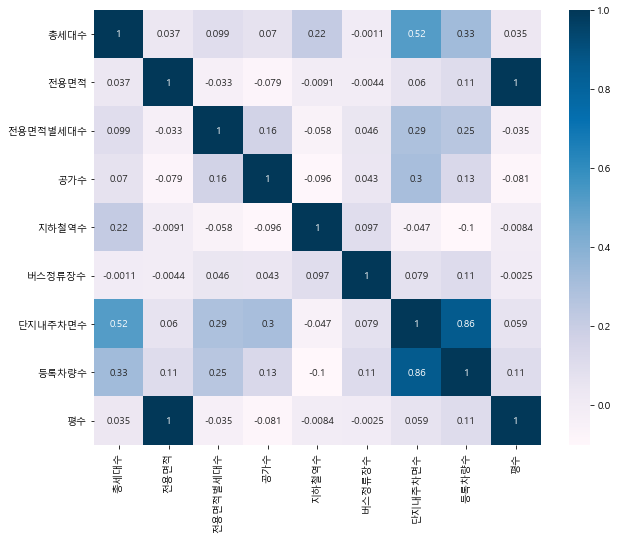

In [19]:
#시각화
df_corr=train.corr()
colormap = plt.cm.PuBu
plt.figure(figsize=(10,8))
sns.heatmap(df_corr,annot=True,cmap=colormap,linecolor='white')

##### 다중공선성은 적으나, target변수와의 상관관계가 낮은듯 => 외부변수, 파생변수 필요
1. 전용면적 -> 평수로 구분 : 평수 범주를 어떻게 나눌것인지?  
2. 지역 피쳐수가 많음 -> 수도권/비수도권 구분 or 광역시/수도권/비수도권 구분해서 피쳐수 줄이는게 좋을듯  
3. 인구밀도 외부 데이터 사용 -> 인구 밀도가 높은 지역일수록 주차수요도 높을것  
4. 가구원수 -> 가구원수에 따라 차 보유 상황이 다를것

### Target변수와 다른 변수간의 그래프

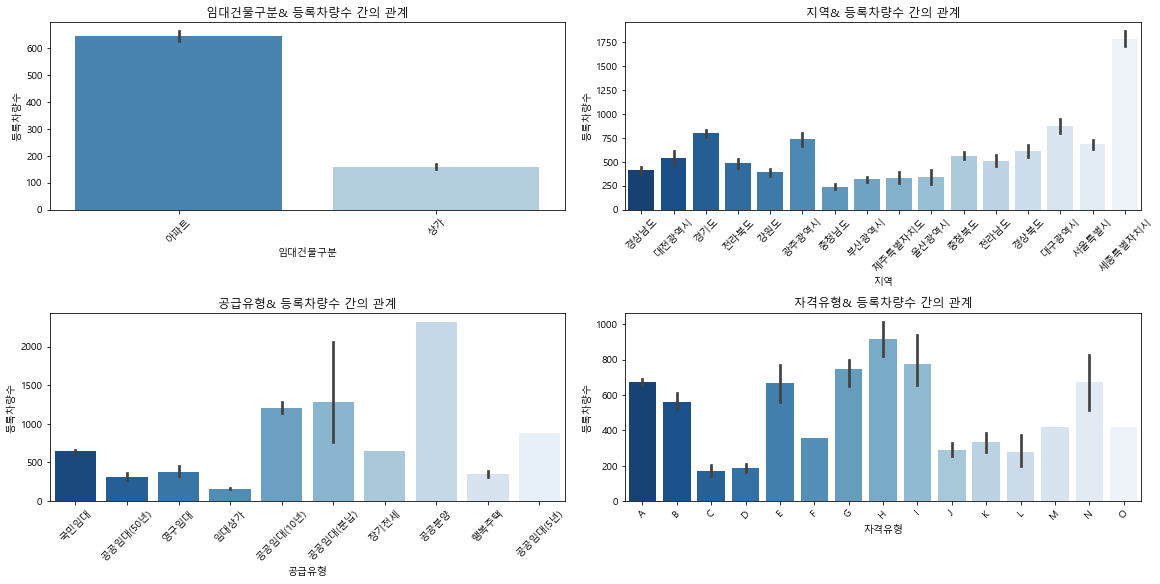

In [20]:
# 1.target + 범주형
df_ct=['임대건물구분','지역','공급유형','자격유형']
f,ax=plt.subplots(2,2,figsize=(16,8),constrained_layout=True)
j=[0,0,1,1]
k=[0,1,0,1]
for i,j,k in zip(df_ct,j,k):
    sns.barplot(x=i,y='등록차량수',data=train,ax=ax[j,k],palette='Blues_r')
    ax[j,k].title.set_text(i+'& 등록차량수 간의 관계')
    plt.rc('font',family='Malgun Gothic')
    plt.rc('axes',unicode_minus=False)
    ax[j,k].set_xticklabels(train[i].unique(),rotation=45)

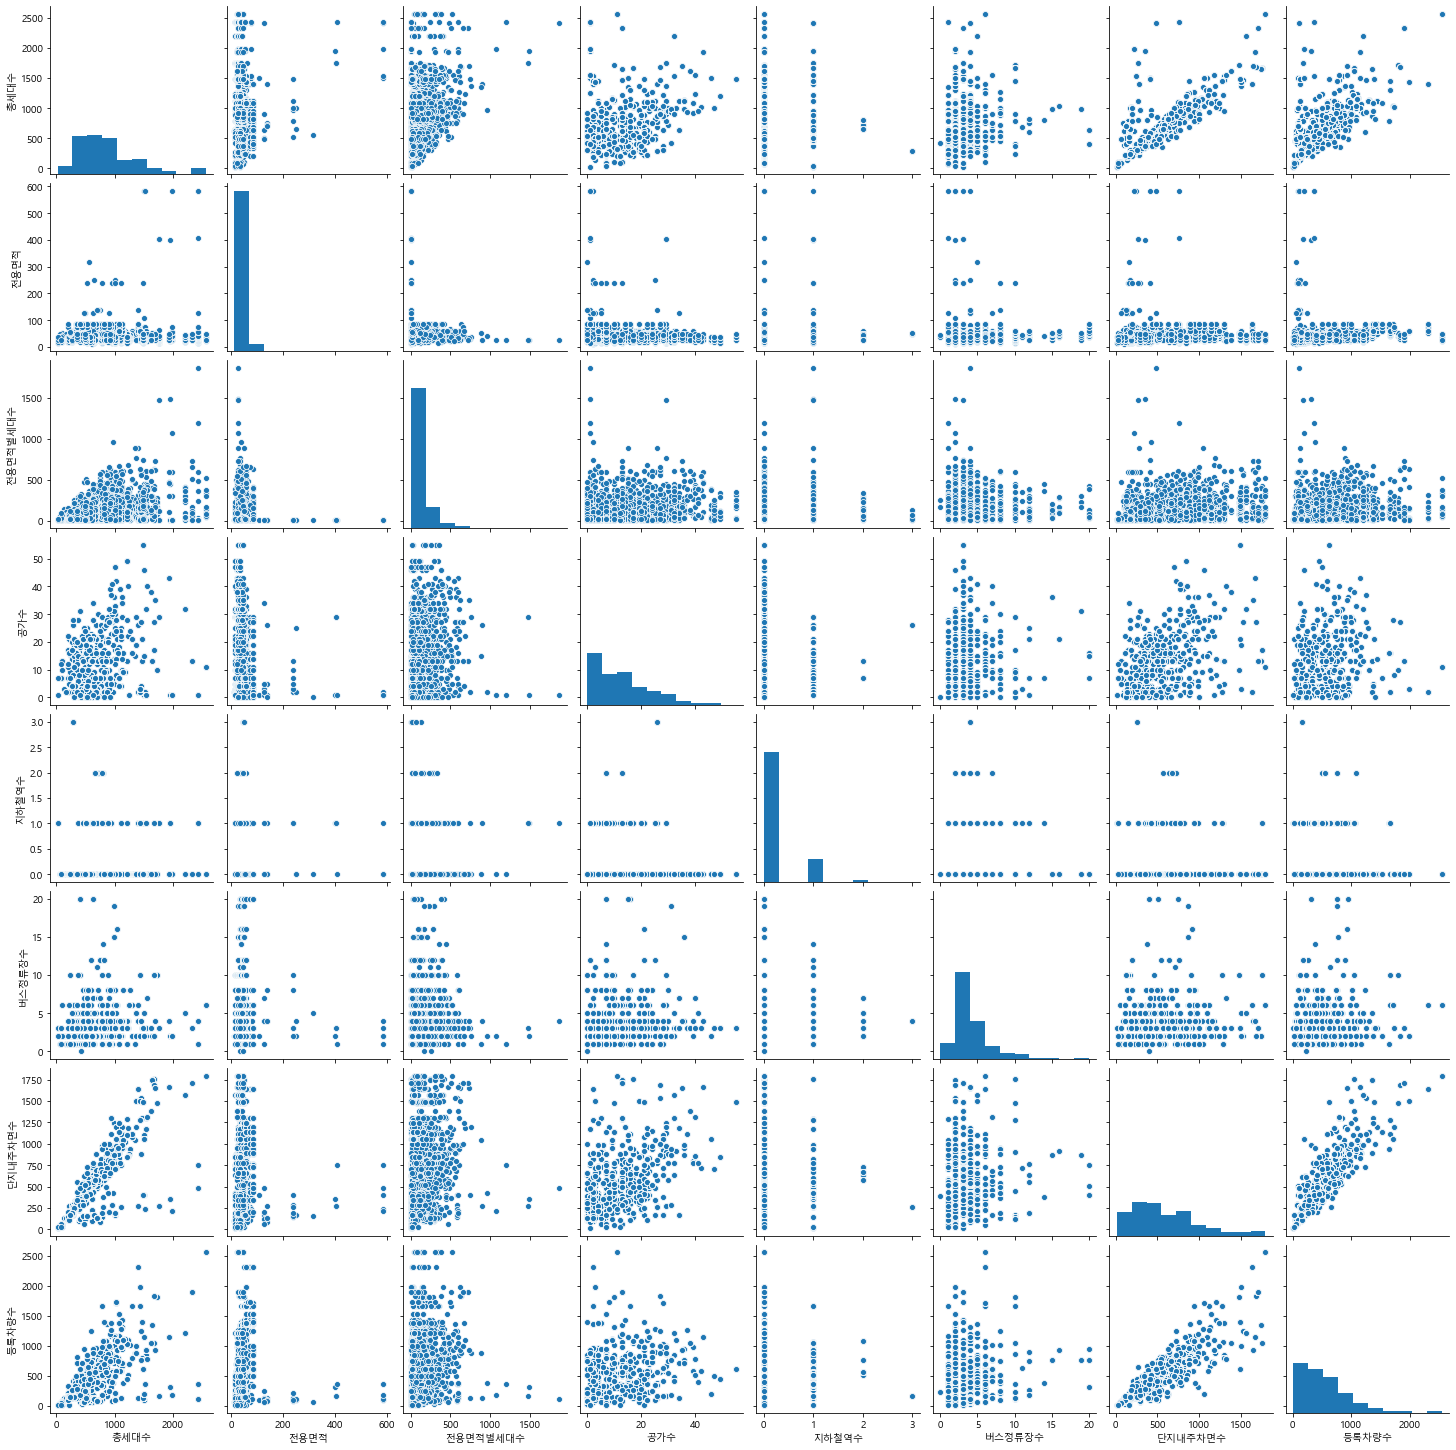

In [21]:
# 2.target + 정수형
df_num=train.loc[:,['총세대수','전용면적','전용면적별세대수','공가수','지하철역수',
        '버스정류장수','단지내주차면수','등록차량수']]
sns.pairplot(df_num,diag_kind='hist')
plt.rc('font',family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)
plt.show()

###### 총세대수 및 단지내주차면수 & 등록차량수 관계가 선형적

---

## 결측치처리

In [22]:
pd.DataFrame(train.isnull().sum())

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,569


In [23]:
#임대보증금,임대료 결측치 확인
df_null=train[train['임대보증금'].isnull()]
df_null

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
80,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,19.0
81,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,19.0
82,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,19.0
83,C1925,601,상가,강원도,임대상가,72.16,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,31.0
93,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,32.0
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0


In [24]:
df_null['지역'].unique()     #특정지역들

array(['강원도', '충청남도', '경상남도', '대전광역시', '부산광역시', '제주특별자치도'], dtype=object)

In [25]:
df_null['자격유형'].unique() #자격유형 D

array(['D'], dtype=object)

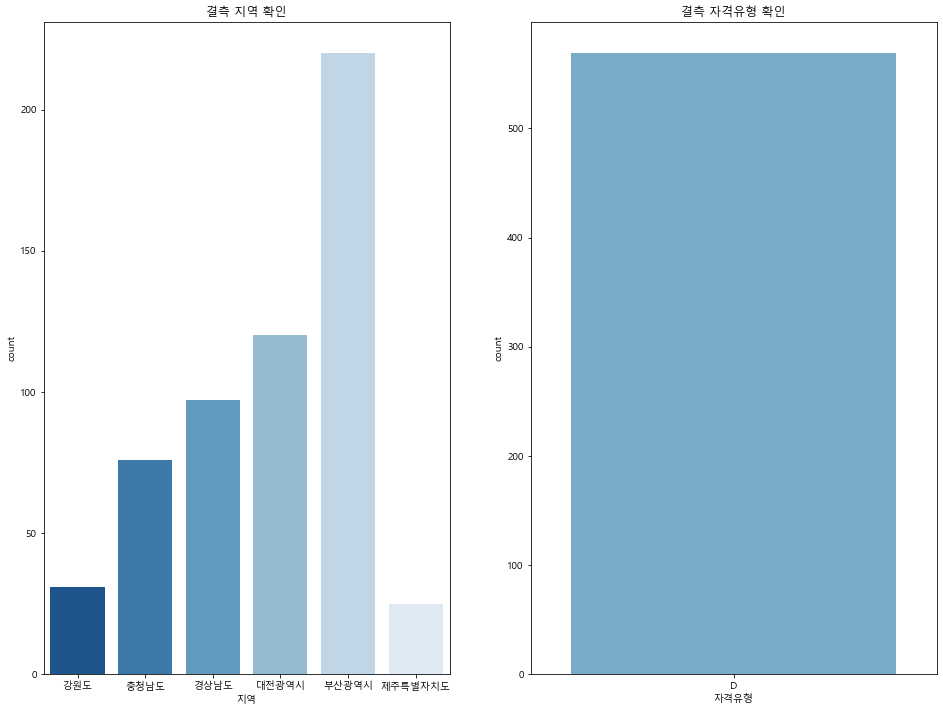

In [26]:
f,ax=plt.subplots(1,2,figsize=(16,12))
sns.countplot(x='지역',data=df_null,ax=ax[0],palette='Blues_r')
ax[0].title.set_text('결측 지역 확인')
plt.rc('font',family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)

sns.countplot(x='자격유형',data=df_null,ax=ax[1],palette='Blues_r')
ax[1].title.set_text('결측 자격유형 확인')
plt.rc('font',family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)

In [27]:
df_null[df_null['임대건물구분']=='아파트']['지역'].unique() #결측치 중 아파트는 대전광역시만

array(['대전광역시'], dtype=object)

In [28]:
df_null[df_null['임대건물구분']=='아파트']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,32.0
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,32.0
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,32.0
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0
2290,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0,36.0


##### 결측치 중 '임대건물구분' 이 아파트인 지역은 모두 대전광역시 -> 왜 임대보증금란이 비어있는지 찾아봐야함
-> 결측치 특징 : 공공분양 = 분양은 임대가 아니므로 임대보증금과 임대료가 있을 필요가 없음.  
-> 공공분양 0으로 처리

### 임대보증금이 - 인 경우, 결측치채우기

In [29]:
df_null2=train[train['임대보증금']=='-']
df_null2

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
2475,C1326,1934,아파트,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0,16.0
2476,C1326,1934,아파트,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1153.0,16.0
2477,C1326,1934,아파트,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1153.0,17.0
2478,C1326,1934,아파트,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1153.0,20.0
2479,C1326,1934,아파트,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1153.0,23.0
2608,C1786,480,아파트,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,345.0,14.0
2609,C1786,480,아파트,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,345.0,17.0
2610,C1786,480,아파트,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,345.0,17.0
2611,C1786,480,아파트,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,345.0,17.0
2823,C2186,924,아파트,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,744.0,18.0


##### 1.부산 임대주택 결측치
LH자료에서 부산정관7 국민임대 평형 사용  

In [30]:
#결측치채우기
#부산광역시 국민임대 (출처:LH)
#임대보증금
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==24.72),'임대보증금']=7505500
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==24.79),'임대보증금']=7505500
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==26.83),'임대보증금']=8148000
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==37.70),'임대보증금']=15868000
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==46.94),'임대보증금']=24768000

#월임대료
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==24.72),'임대료']=114740
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==24.79),'임대료']=114740
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==26.83),'임대료']=152250
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==37.70),'임대료']=212290
train.loc[(train['단지코드']=='C1326')&(train['전용면적']==46.94),'임대료']=277690

##### 2. 강원도 행복주택 결측치
총 두가지 유형 (소득 유무)이 있으므로 두 금액의 평균 이용

In [31]:
#강원도 행복주택
#임대보증금
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==16.91),'임대보증금']=(13181000+13957000)/2
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==26.90),'임대보증금']=(19397000+20538000)/2
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==26.90),'임대보증금']=(19397000+20538000)/2
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==26.90),'임대보증금']=(19397000+20538000)/2

#임대료
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==16.91),'임대료']=(62610+66290)/2
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==26.90),'임대료']=(92130+97550)/2
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==26.90),'임대료']=(92130+97550)/2
train.loc[(train['단지코드']=='C1786')&(train['전용면적']==26.90),'임대료']=(92130+97550)/2

##### 3. 대구광역시 임대주택 결측치

In [32]:
#대구광역시 임대주택 결측치
#임대보증금
train.loc[(train['단지코드']=='C2186')&(train['전용면적']==29.17),'임대보증금']=9692000
train.loc[(train['단지코드']=='C2186')&(train['전용면적']==29.34),'임대보증금']=9692000
train.loc[(train['단지코드']=='C2186')&(train['전용면적']==37.43),'임대보증금']=18319000

#임대료
train.loc[(train['단지코드']=='C2186')&(train['전용면적']==29.17),'임대료']=147880
train.loc[(train['단지코드']=='C2186')&(train['전용면적']==29.34),'임대료']=147880
train.loc[(train['단지코드']=='C2186')&(train['전용면적']==37.43),'임대료']=210240

##### (4) TEST - 부산 행복주택 결측치

In [33]:
#부산 행복주택
#임대보증금
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==16.94),'임대보증금']=(10880000+11520000)/2
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==26.85)&(test['전용면적별세대수']==66),'임대보증금']=(16660000+17640000+14700000)/3
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==26.85)&(test['전용면적별세대수']==8),'임대보증금']=18620000
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==36.77),'임대보증금']=(23760000+26400000+19800000+25080000)/4

#임대료
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==16.94),'임대료']=(51680+54720)/2
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==26.85)&(test['전용면적별세대수']==66),'임대료']=(79130+83790+69820)/3
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==26.85)&(test['전용면적별세대수']==8),'임대료']=88440
test.loc[(test['단지코드']=='C1267')&(test['전용면적']==36.77),'임대료']=(112860+125400+94050+119130)/4

##### (5) TEST - 강원도 영구임대 결측치

In [34]:
#강원도 영구임대
#임대보증금
test.loc[(test['단지코드']=='C2152')&(test['전용면적']==24.83),'임대보증금']=8560000
test.loc[(test['단지코드']=='C2152')&(test['전용면적']==33.84),'임대보증금']=11667000

#임대료
test.loc[(test['단지코드']=='C2152')&(test['전용면적']==24.83),'임대료']=87040
test.loc[(test['단지코드']=='C2152')&(test['전용면적']==33.84),'임대료']=118630

##### (6) TEST - 대전광역시 영구임대 결측치

In [35]:
#대전광역시 영구임대 결측치
#임대보증금
test.loc[(test['단지코드']=='C1006')&(test['전용면적']==26.37),'임대보증금']=5787000
test.loc[(test['단지코드']=='C1006')&(test['전용면적']==52.74),'임대보증금']=11574000

#임대료
test.loc[(test['단지코드']=='C1006')&(test['전용면적']==26.37),'임대료']=79980
test.loc[(test['단지코드']=='C1006')&(test['전용면적']==52.74),'임대료']=159960

##### 공공분양엔 임대료/임대보증금 0 넣기

In [36]:
temp_index = train[train['공급유형']=='공공분양'].index
train.임대료[temp_index]=0
train.임대보증금[temp_index]=0

<ipython-input-36-506c1d8bd443>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.임대료[temp_index]=0
<ipython-input-36-506c1d8bd443>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.임대보증금[temp_index]=0


##### 장기전세엔 임대료 0 넣기

In [37]:
train[train['임대료']=='-']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
2073,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,645.0,25.0
2074,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,645.0,27.0
2075,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,645.0,27.0


In [38]:
temp_index = train[train['공급유형']=='장기전세'].index
train.임대료[temp_index]=0

<ipython-input-38-ff8fdbf160bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.임대료[temp_index]=0


In [39]:
train.임대료 = train.임대료.astype('float')
train.임대보증금 = train.임대보증금.astype('float')

In [40]:
#아파트/상가 데이터 나누기 -> 맨밑에 지도확인위함
df_ap=train[train['임대건물구분']=='아파트']
df_bd=train[train['임대건물구분']=='상가']

### 범주형 데이터 범주 확인

In [41]:
def 범주확인(col):
    temp_list = list(set(train[col]))
    return temp_list

In [42]:
print('임대건물구분 : ', 범주확인('임대건물구분'))
print('지역 : ', 범주확인('지역'))
print('공급유형 : ', 범주확인('공급유형'))
print('자격유형 : ', 범주확인('자격유형'))

임대건물구분 :  ['상가', '아파트']
지역 :  ['전라북도', '충청북도', '서울특별시', '대전광역시', '부산광역시', '대구광역시', '광주광역시', '충청남도', '세종특별자치시', '경상남도', '울산광역시', '전라남도', '경상북도', '강원도', '경기도', '제주특별자치도']
공급유형 :  ['국민임대', '장기전세', '공공임대(50년)', '공공임대(분납)', '영구임대', '공공임대(5년)', '임대상가', '공공분양', '공공임대(10년)', '행복주택']
자격유형 :  ['N', 'B', 'G', 'J', 'C', 'L', 'I', 'E', 'O', 'K', 'H', 'A', 'D', 'F', 'M']


## 안채워진 결측지 각 변수와의 관계파악

In [43]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       562
임대료         562
지하철역수       207
버스정류장수        0
단지내주차면수       0
등록차량수         0
평수            0
dtype: int64

### 두변수의 결측치가 같은지 확인


In [44]:
# 두변수의 결측치가 같은지 확인

tm_index_1 = train[train['임대보증금'].isnull()].index
tm_index_2 = train[train['임대료'].isnull()].index
for i in tm_index_1:
    if i in tm_index_2:
        pass
    else:
        print(i)
# 결측치는 완전히 일치함

### 결측치와 각종 범주형 변수와의 관계 파악

In [45]:
def 지역별결측치조회(region):
    tmp_index = train[(train['임대료'].isnull()) & (train['지역']==region)].index
    return train.loc[tmp_index][['지역', '임대료']]

In [46]:
# 결측치와 각종 범주형 변수와의 관계 파악
region_list = list(set(train['지역']))
temp1 = []; temp2 = []; temp3 = []; temp4 = []; temp5 = []; temp6 = []; temp7 = []
for i in region_list:
    index_list = train[(train['임대료'].isnull()) & (train['지역']==i)].index
    temp1.append(i); temp2.append(len(지역별결측치조회(i))); temp3.append(len(train[train['지역']==i])); temp4.append(list(set(train.loc[index_list]['공급유형'])))
    temp5.append(list(set(train.loc[index_list]['임대건물구분']))); temp6.append(list(set(train.loc[index_list]['자격유형'])));  temp7.append(list(set(train.loc[index_list]['단지코드']))); 
null_df = pd.DataFrame({'지역':temp1, '해당 지역의 결측치 개수':temp2, '해당 지역의 데이터 개수':temp3, '결측치의 공급유형':temp4, '결측치의 임대건물구분':temp5, '결측치의 자격유형':temp6, '결측치의 단지코드':temp7})
null_df

,지역,해당 지역의 결측치 개수,해당 지역의 데이터 개수,결측치의 공급유형,결측치의 임대건물구분,결측치의 자격유형,결측치의 단지코드
0,전라북도,0,109,[],[],[],[]
1,충청북도,0,163,[],[],[],[]
2,서울특별시,0,50,[],[],[],[]
3,대전광역시,113,266,[임대상가],[상가],[D],"[C2621, C2038, C1704, C1616, C2258, C1859]"
4,부산광역시,220,328,[임대상가],[상가],[D],"[C1439, C2597, C2135, C1109, C2289, C2310, C21..."
5,대구광역시,0,102,[],[],[],[]
6,광주광역시,0,141,[],[],[],[]
7,충청남도,76,158,[임대상가],[상가],[D],"[C1874, C1004, C2644, C1983, C1875]"
8,세종특별자치시,0,24,[],[],[],[]
9,경상남도,97,363,[임대상가],[상가],[D],"[C1899, C2190, C2109, C1698, C1790, C1476, C24..."


### 지역별 지하철역수 확인

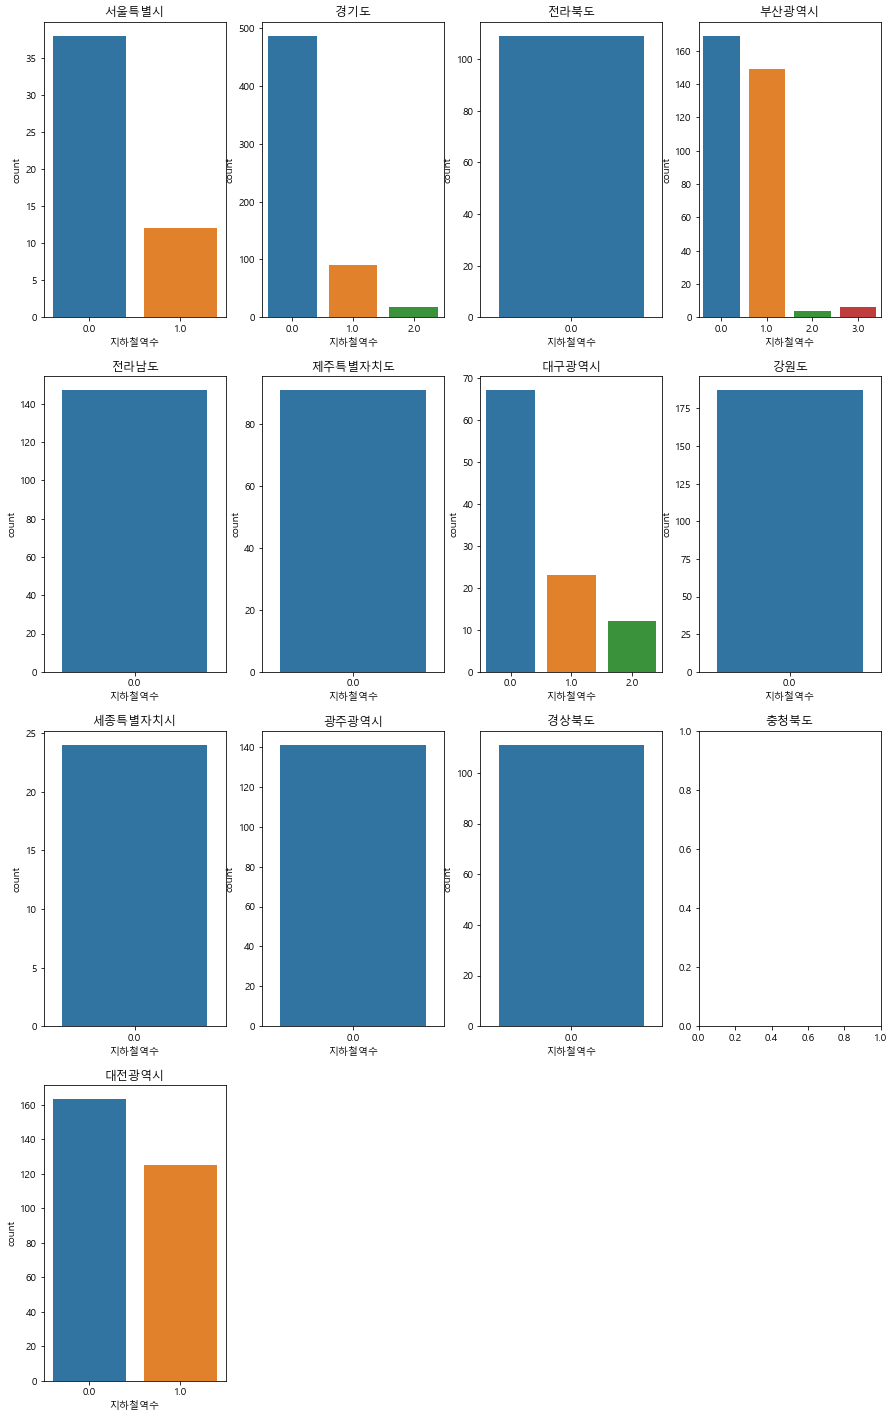

In [47]:
fig = plt.figure(figsize=(15,25))

area01 = fig.add_subplot(4,4,1)
area01.set_title('서울특별시')

area02 = fig.add_subplot(4,4,2)
area02.set_title('경기도')

area03 = fig.add_subplot(4,4,3)
area03.set_title('전라북도')

area04 = fig.add_subplot(4,4,4)
area04.set_title('부산광역시')

area05 = fig.add_subplot(4,4,5)
area05.set_title('전라남도')

area06 = fig.add_subplot(4,4,6)
area06.set_title('제주특별자치도')

area07 = fig.add_subplot(4,4,7)
area07.set_title('대구광역시')

area08 = fig.add_subplot(4,4,8)
area08.set_title('강원도')

area09 = fig.add_subplot(4,4,9)
area09.set_title('세종특별자치시')

area10 = fig.add_subplot(4,4,10)
area10.set_title('광주광역시')

area11 = fig.add_subplot(4,4,11)
area11.set_title('경상북도')

area12 = fig.add_subplot(4,4,12)
area12.set_title('충청북도')

area12 = fig.add_subplot(4,4,13)
area12.set_title('대전광역시')

train_region = train[train['지역']=='서울특별시']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area01)

train_region = train[train['지역']=='경기도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area02)

train_region = train[train['지역']=='전라북도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area03)

train_region = train[train['지역']=='부산광역시']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area04)

train_region = train[train['지역']=='전라남도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area05)

train_region = train[train['지역']=='제주특별자치도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area06)

train_region = train[train['지역']=='대구광역시']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area07)

train_region = train[train['지역']=='강원도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area08)

train_region = train[train['지역']=='세종특별자치시']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area09)

train_region = train[train['지역']=='광주광역시']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area10)

train_region = train[train['지역']=='경상북도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area11)

train_region = train[train['지역']=='충청북도']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area12)

train_region = train[train['지역']=='대전광역시']
region_list = train_region['지하철역수']
sns.countplot(region_list, ax=area12)

---

## 지하철역수 결측치 채우기

In [48]:
#지하철역수 결측치
df_sw=train[train['지하철역수'].isnull()]
df_sw

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
86,C1312,518,아파트,충청남도,국민임대,39.72,60,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0,21.0
87,C1312,518,아파트,충청남도,국민임대,39.98,89,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0,21.0
88,C1312,518,아파트,충청남도,국민임대,41.55,225,12.0,A,19954000.0,130940.0,NaN,3.0,527.0,359.0,22.0
89,C1312,518,아파트,충청남도,국민임대,46.90,143,12.0,A,28687000.0,149660.0,NaN,3.0,527.0,359.0,23.0
90,C1874,619,아파트,충청남도,영구임대,26.37,294,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,C1350,1401,아파트,대전광역시,공공임대(10년),59.91,13,2.0,A,37474000.0,519350.0,NaN,6.0,1636.0,2315.0,27.0
2293,C1350,1401,아파트,대전광역시,공공임대(10년),59.92,223,2.0,A,37385000.0,516130.0,NaN,6.0,1636.0,2315.0,27.0
2294,C1350,1401,아파트,대전광역시,공공임대(분납),51.99,146,2.0,A,54612000.0,131130.0,NaN,6.0,1636.0,2315.0,25.0
2295,C1350,1401,아파트,대전광역시,공공임대(분납),59.91,32,2.0,A,63585000.0,152680.0,NaN,6.0,1636.0,2315.0,27.0


In [49]:
df_sw['지역'].unique() # 충남,대전(충청남도)만 존재

array(['충청남도', '대전광역시'], dtype=object)

In [50]:
df_sw['단지코드'].unique()

array(['C1312', 'C1874', 'C1424', 'C2100', 'C2520', 'C1616', 'C1704',
       'C2258', 'C1068', 'C1983', 'C2216', 'C2644', 'C1005', 'C1004',
       'C1875', 'C2156', 'C1175', 'C2583', 'C1350'], dtype=object)

In [51]:
df_sw['자격유형'].unique() # C:영구임대,D:공공분양,임대상가 E:국민임대,영구임대, I:영구임대

array(['A', 'C', 'D', 'E', 'I'], dtype=object)

### 지하철역수 채우기 

In [52]:
train['지하철역수'].unique()

array([ 0.,  1., nan,  2.,  3.])

In [53]:
train.loc[train['단지코드']=='C1312']  #아파트(국민임대)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
86,C1312,518,아파트,충청남도,국민임대,39.72,60,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0,21.0
87,C1312,518,아파트,충청남도,국민임대,39.98,89,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0,21.0
88,C1312,518,아파트,충청남도,국민임대,41.55,225,12.0,A,19954000.0,130940.0,NaN,3.0,527.0,359.0,22.0
89,C1312,518,아파트,충청남도,국민임대,46.90,143,12.0,A,28687000.0,149660.0,NaN,3.0,527.0,359.0,23.0


In [54]:
## C1312 = 공주신관6 / 충청남도 공주시 관골2길 36   [주변지하철:0]
train.loc[train['단지코드']=='C1312','지하철역수']= 0

In [55]:
train.loc[train['단지코드']=='C1874']  # 아파트, 상가 모두존재 
train[(train['단지코드']=='C1874') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
90,C1874,619,아파트,충청남도,영구임대,26.37,294,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0,17.0
91,C1874,619,아파트,충청남도,영구임대,26.37,149,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0,17.0
92,C1874,619,아파트,충청남도,영구임대,31.32,149,2.0,C,3731000.0,83020.0,NaN,2.0,97.0,62.0,18.0


In [56]:
## C1874 = 보령명천2 / 충청남도 보령시 주공로 50   [주변지하철:0]
train.loc[train['단지코드']=='C1874','지하철역수']= 0

---

#### 대전광역시는 주택관리공단 홈페이지 확인
https://www.kohom.or.kr/web/mainComm/HM001002002.do?mode=view&schDo=0600000&schCon=0&schStr=%EA%B3%B5%EA%B3%B5%EC%9E%84%EB%8C%80&page=1&p_idx=12242

In [57]:
train.loc[train['단지코드']=='C1424']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
136,C1424,625,아파트,대전광역시,공공임대(50년),39.99,268,2.0,A,14247000.0,198980.0,NaN,7.0,517.0,179.0,21.0
137,C1424,625,아파트,대전광역시,공공임대(50년),49.95,119,2.0,A,20173000.0,225100.0,NaN,7.0,517.0,179.0,24.0
138,C1424,625,아파트,대전광역시,공공임대(50년),49.95,237,2.0,A,21203000.0,225100.0,NaN,7.0,517.0,179.0,24.0


In [58]:
## C1424 = 대전광역시 서구 관저로 84    [주변지하철:0]
train.loc[train['단지코드']=='C1424','지하철역수']= 0

In [59]:
train.loc[train['단지코드']=='C2100']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
139,C2100,880,아파트,대전광역시,국민임대,51.51,46,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0,25.0
140,C2100,880,아파트,대전광역시,국민임대,51.59,35,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0,25.0
141,C2100,880,아파트,대전광역시,국민임대,51.90,589,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0,25.0
142,C2100,880,아파트,대전광역시,국민임대,59.91,118,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0,27.0
143,C2100,880,아파트,대전광역시,국민임대,59.94,46,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0,27.0
144,C2100,880,아파트,대전광역시,국민임대,59.99,46,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0,27.0


In [60]:
## C2100 = 대전느리울13단지 / 대전광역시 서구 관저동로 42  [주변지하철:0 ]
train.loc[train['단지코드']=='C2100','지하철역수']= 0

In [61]:
train.loc[train['단지코드']=='C2520']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
163,C2520,970,아파트,대전광역시,공공임대(50년),39.69,960,2.0,A,13155000.0,177500.0,NaN,2.0,420.0,386.0,21.0


In [62]:
## C2520 = 대전문화1단지 / 대전광역시 중구 보문산로 161번길 55   [주변지하철:0]
train.loc[train['단지코드']=='C2520','지하철역수']= 0

In [63]:
train.loc[train['단지코드']=='C1616']  
train[(train['단지코드']=='C1616') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
168,C1616,1507,아파트,대전광역시,영구임대,26.37,588,1.0,C,5787000.0,79980.0,NaN,2.0,407.0,98.0,17.0
169,C1616,1507,아파트,대전광역시,영구임대,31.32,450,1.0,C,6873000.0,94990.0,NaN,2.0,407.0,98.0,18.0
170,C1616,1507,아파트,대전광역시,영구임대,40.32,450,1.0,E,54040000.0,28140.0,NaN,2.0,407.0,98.0,21.0


In [64]:
## C1616 = 대전광역시 대덕구 계족로 663번길 34   *** [주변지하철:0] 기차역존재(대전조차장역)
train.loc[train['단지코드']=='C1616','지하철역수']= 0

In [65]:
train.loc[train['단지코드']=='C1704']  
train[(train['단지코드']=='C1704') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
190,C1704,639,아파트,대전광역시,영구임대,39.30,204,34.0,C,8625000.0,119190.0,NaN,7.0,162.0,131.0,21.0
191,C1704,639,아파트,대전광역시,영구임대,39.69,420,34.0,C,8710000.0,120370.0,NaN,7.0,162.0,131.0,21.0


In [66]:
## C1704 = 대전광역시 동구 산내로 1352-25   [주변지하철:0]
train.loc[train['단지코드']=='C1704','지하철역수']= 0

In [67]:
train.loc[train['단지코드']=='C2258']  
train[(train['단지코드']=='C2258') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
207,C2258,965,아파트,대전광역시,영구임대,26.37,588,13.0,C,5787000.0,79980.0,NaN,3.0,287.0,78.0,17.0
208,C2258,965,아파트,대전광역시,영구임대,31.32,180,13.0,C,6873000.0,94990.0,NaN,3.0,287.0,78.0,18.0
209,C2258,965,아파트,대전광역시,영구임대,40.32,180,13.0,C,8848000.0,122290.0,NaN,3.0,287.0,78.0,21.0


In [68]:
## C2258= 대전광역시 중구 대전천서로 695    [주변지하철:0]
train.loc[train['단지코드']=='C2258','지하철역수']= 0

In [69]:
train.loc[train['단지코드']=='C1068']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
339,C1068,806,아파트,충청남도,국민임대,36.65,200,11.0,A,11234000.0,106090.0,NaN,2.0,804.0,510.0,20.0
340,C1068,806,아파트,충청남도,국민임대,36.98,130,11.0,A,11234000.0,106090.0,NaN,2.0,804.0,510.0,20.0
341,C1068,806,아파트,충청남도,국민임대,41.55,252,11.0,A,14981000.0,124830.0,NaN,2.0,804.0,510.0,22.0
342,C1068,806,아파트,충청남도,국민임대,46.86,44,11.0,A,18726000.0,149810.0,NaN,2.0,804.0,510.0,23.0
343,C1068,806,아파트,충청남도,국민임대,46.98,88,11.0,A,18726000.0,149810.0,NaN,2.0,804.0,510.0,23.0
344,C1068,806,아파트,충청남도,국민임대,51.93,91,11.0,A,24343000.0,168520.0,NaN,2.0,804.0,510.0,25.0


In [70]:
## C1068 = 보령동대4 / 충청남도 보령시 한내로터리길 92    [주변지하철:0]
train.loc[train['단지코드']=='C1068','지하철역수']= 0

In [71]:
train.loc[train['단지코드']=='C1983']  
train[(train['단지코드']=='C1983') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
345,C1983,903,아파트,충청남도,공공임대(50년),36.00,40,3.0,A,10363000.0,149010.0,NaN,4.0,200.0,253.0,20.0
346,C1983,903,아파트,충청남도,공공임대(50년),35.28,198,3.0,A,10060000.0,145290.0,NaN,4.0,200.0,253.0,20.0
347,C1983,903,아파트,충청남도,공공임대(50년),35.28,78,3.0,A,10060000.0,145290.0,NaN,4.0,200.0,253.0,20.0
348,C1983,903,아파트,충청남도,영구임대,26.37,478,3.0,C,8083000.0,124180.0,NaN,4.0,200.0,253.0,17.0
349,C1983,903,아파트,충청남도,영구임대,31.32,99,3.0,C,9670000.0,142850.0,NaN,4.0,200.0,253.0,18.0


In [72]:
## C1983 = 보령명천2단지 / 충청남도 보령시 주공로 50    [주변지하철:0]
train.loc[train['단지코드']=='C1983','지하철역수']= 0

In [73]:
train.loc[train['단지코드']=='C2216']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
612,C2216,390,아파트,충청남도,공공임대(50년),39.00,210,2.0,A,9401000.0,132480.0,NaN,1.0,97.0,149.0,21.0
613,C2216,390,아파트,충청남도,공공임대(50년),39.39,180,2.0,A,9493000.0,133340.0,NaN,1.0,97.0,149.0,21.0


In [74]:
## C2216 = 부여쌍북2단지 / 충청남도 부여군 부여읍 성왕로328번길 15    [주변지하철:0]
train.loc[train['단지코드']=='C2216','지하철역수']= 0

In [75]:
train.loc[train['단지코드']=='C2644']
train[(train['단지코드']=='C2644') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
632,C2644,779,아파트,충청남도,공공임대(50년),37.67,89,7.0,A,11879000.0,161250.0,NaN,12.0,190.0,177.0,20.0
633,C2644,779,아파트,충청남도,공공임대(50년),37.67,298,7.0,A,11879000.0,161250.0,NaN,12.0,190.0,177.0,20.0
634,C2644,779,아파트,충청남도,영구임대,26.37,239,7.0,C,8684000.0,127670.0,NaN,12.0,190.0,177.0,17.0
635,C2644,779,아파트,충청남도,영구임대,26.37,149,7.0,C,8684000.0,127670.0,NaN,12.0,190.0,177.0,17.0


In [76]:
## C2644 = 서산석림3단지 / 충청남도 서산시 석림4로 83    [주변지하철:0]
train.loc[train['단지코드']=='C2644','지하철역수']= 0

In [77]:
train.loc[train['단지코드']=='C1005']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
753,C1005,1144,아파트,충청남도,국민임대,51.49,304,16.0,A,16205000.0,208470.0,NaN,8.0,950.0,376.0,25.0
754,C1005,1144,아파트,충청남도,국민임대,51.95,600,16.0,A,16348000.0,210900.0,NaN,8.0,950.0,376.0,25.0
755,C1005,1144,아파트,충청남도,국민임대,59.64,240,16.0,A,18770000.0,246770.0,NaN,8.0,950.0,376.0,27.0


In [78]:
## C1005 = 천안백석3/ 충청남도 천안시 서북구 백석3로 70   [주변지하철:0]
train.loc[train['단지코드']=='C1005','지하철역수']= 0

In [79]:
train.loc[train['단지코드']=='C1004']  
train[(train['단지코드']=='C1004') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
756,C1004,521,아파트,충청남도,영구임대,39.30,240,3.0,C,4682000.0,104180.0,NaN,2.0,153.0,93.0,21.0
757,C1004,521,아파트,충청남도,영구임대,39.69,264,3.0,C,4728000.0,105210.0,NaN,2.0,153.0,93.0,21.0


In [80]:
## C1004 = 천안성정4 / 충청남도 천안시 서북구 쌍용대로289-28   [주변지하철:0]
train.loc[train['단지코드']=='C1004','지하철역수']= 0

In [81]:
train.loc[train['단지코드']=='C1875']  
train[(train['단지코드']=='C1875') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
775,C1875,1003,아파트,충청남도,영구임대,26.37,596,5.0,C,3141000.0,69900.0,NaN,8.0,192.0,209.0,17.0
776,C1875,1003,아파트,충청남도,영구임대,26.37,239,5.0,C,3141000.0,69900.0,NaN,8.0,192.0,209.0,17.0
777,C1875,1003,아파트,충청남도,영구임대,31.32,149,5.0,C,3731000.0,83020.0,NaN,8.0,192.0,209.0,18.0


In [82]:
## C1875 = 아산읍내 / 충청남도 아산시 외암로 1420   [주변지하철:0]
train.loc[train['단지코드']=='C1875','지하철역수']= 0

In [83]:
train.loc[train['단지코드']=='C2156']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
797,C2156,306,아파트,충청남도,국민임대,36.55,120,0.0,A,8670000.0,80500.0,NaN,1.0,246.0,204.0,20.0
798,C2156,306,아파트,충청남도,국민임대,39.57,120,0.0,A,11147000.0,90410.0,NaN,1.0,246.0,204.0,21.0
799,C2156,306,아파트,충청남도,국민임대,51.93,65,0.0,A,19819000.0,127580.0,NaN,1.0,246.0,204.0,25.0


In [84]:
## C2156 = 청양읍내2단지 / 충청남도 청양군 청양읍 고리섬들길 53   [주변지하철:0]
train.loc[train['단지코드']=='C2156','지하철역수']= 0

In [85]:
train.loc[train['단지코드']=='C1175']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
831,C1175,468,아파트,충청남도,국민임대,46.90,198,15.0,A,21134000.0,128070.0,NaN,2.0,477.0,430.0,23.0
832,C1175,468,아파트,충청남도,국민임대,51.93,90,15.0,A,26258000.0,160100.0,NaN,2.0,477.0,430.0,25.0
833,C1175,468,아파트,충청남도,국민임대,59.88,180,15.0,A,34585000.0,204940.0,NaN,2.0,477.0,430.0,27.0


In [86]:
## C1175 = 홍성남장2 / 충청남도 홍성군 홍성읍 문화로72번길 72   [주변지하철:0]
train.loc[train['단지코드']=='C1175','지하철역수']= 0

In [87]:
train.loc[train['단지코드']=='C2583']  

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
2242,C2583,1106,아파트,대전광역시,국민임대,36.85,24,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0,20.0
2243,C2583,1106,아파트,대전광역시,국민임대,36.85,70,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0,20.0
2244,C2583,1106,아파트,대전광역시,국민임대,36.93,604,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0,20.0
2245,C2583,1106,아파트,대전광역시,국민임대,36.93,24,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0,20.0
2246,C2583,1106,아파트,대전광역시,국민임대,46.78,72,21.0,A,26774000.0,254840.0,NaN,2.0,752.0,982.0,23.0
2247,C2583,1106,아파트,대전광역시,국민임대,46.78,72,21.0,A,26774000.0,254840.0,NaN,2.0,752.0,982.0,23.0
2248,C2583,1106,아파트,대전광역시,영구임대,21.97,60,21.0,I,7175000.0,69250.0,NaN,2.0,752.0,982.0,16.0
2249,C2583,1106,아파트,대전광역시,영구임대,26.90,60,21.0,I,8707000.0,84230.0,NaN,2.0,752.0,982.0,17.0
2250,C2583,1106,아파트,대전광역시,영구임대,26.90,36,21.0,I,8707000.0,84230.0,NaN,2.0,752.0,982.0,17.0
2251,C2583,1106,아파트,대전광역시,영구임대,26.90,72,21.0,I,8707000.0,84230.0,NaN,2.0,752.0,982.0,17.0


In [88]:
## C2583 = 대전관저5 천년나무1단지   [주변지하철:0]
train.loc[train['단지코드']=='C2583','지하철역수']= 0

In [89]:
train.loc[train['단지코드']=='C1350']  
train[(train['단지코드']=='C1350') & (train['임대건물구분']=='아파트')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,32.0
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,32.0
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,32.0
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,36.0
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,36.0
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,36.0
2290,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0,36.0
2291,C1350,1401,아파트,대전광역시,공공임대(10년),51.99,106,2.0,A,28013000.0,408600.0,NaN,6.0,1636.0,2315.0,25.0
2292,C1350,1401,아파트,대전광역시,공공임대(10년),59.91,13,2.0,A,37474000.0,519350.0,NaN,6.0,1636.0,2315.0,27.0
2293,C1350,1401,아파트,대전광역시,공공임대(10년),59.92,223,2.0,A,37385000.0,516130.0,NaN,6.0,1636.0,2315.0,27.0


In [90]:
## C1350 = 다온숲3단지 / 대전광역시 서구 구봉산북로 165  [주변지하철:0]
train.loc[train['단지코드']=='C1350','지하철역수']= 0

In [91]:
pd.DataFrame(train.isnull().sum())

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,562


## 임대상가 결측치처리
##### -> randomforest regressor로 예측값 대입하기

* #### 문자형 데이터 수치형으로 범주화

In [92]:
def 리스트만들기1(col):
    temp_list = list(set(train[col]))
    new_list = []
    for i in range(len(temp_list)):
        new_list.append(temp_list[i])
    return new_list

In [93]:
# 범주형데이터 수치형으로 전환
list1_0 = 리스트만들기1('단지코드')
list1_1 = 리스트만들기1('임대건물구분')
list1_2 = 리스트만들기1('지역')
list1_3 = 리스트만들기1('자격유형')

In [94]:
region_list = list1_2 # 추후 병합을 위함

In [95]:
for i in train.index:
    train.단지코드[i] = list1_0.index(train.단지코드[i])
    train.임대건물구분[i] = list1_1.index(train.임대건물구분[i])
    train.지역[i] = list1_2.index(train.지역[i])
    train.자격유형[i] = list1_3.index(train.자격유형[i])

<ipython-input-95-14610b846550>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.단지코드[i] = list1_0.index(train.단지코드[i])
<ipython-input-95-14610b846550>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.임대건물구분[i] = list1_1.index(train.임대건물구분[i])
<ipython-input-95-14610b846550>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.지역[i] = list1_2.index(train.지역[i])
<ipython-input-95-14610b846550>:5: SettingWithCopyWarning: 
A

* #### 데이터준비

test셋에도 동일한 전처리를 적용한다 가정하면 target변수는 빼고 진행해야함

In [96]:
train_notna = train[train['공급유형'] != '임대상가'].reset_index()
temp_notna_공급유형 = train_notna['공급유형']
temp_notna_등록차량수 = train_notna['등록차량수']
train_notna = train_notna.drop(['공급유형', '등록차량수'],axis=1)

train_na = train[train['공급유형'] == '임대상가'].reset_index()
temp_na_등록차량수 = train_na['등록차량수']
train_na = train_na.drop(['공급유형', '임대보증금', '임대료', '등록차량수'],axis=1)

* #### 머신러닝(Regression) 진행

In [97]:
# 임대상가의 임대료 채우기 
train_notna_feat = train_notna.drop(['임대보증금', '임대료'], axis=1)
train_notna_lab1 = train_notna['임대료']

x_train1, x_test1, y_train1, y_test1  = train_test_split(train_notna_feat, train_notna_lab1, test_size=0.2)

model1 = RandomForestRegressor()
model1.fit(x_train1, y_train1)
print(model1.score(x_train1, y_train1))
print(model1.score(x_test1, y_test1))

train_na_result1 = model1.predict(train_na)

0.9877688222899516
0.9369369641919516


In [98]:
# 임대상가의 임대보증금채우기 
train_notna_lab2 = train_notna['임대보증금']

x_train2, x_test2, y_train2, y_test2  = train_test_split(train_notna_feat, train_notna_lab2, test_size=0.2)

model2 = RandomForestRegressor()
model2.fit(x_train2, y_train2)
print(model2.score(x_train2, y_train2))
print(model2.score(x_test2, y_test2))

train_na_result2 = model2.predict(train_na)

0.9791861613792606
0.9142982481155509


* #### 원데이터와 합치기

In [99]:
train_na['임대료']=train_na_result1
train_na['임대보증금']=train_na_result2

In [100]:
train_notna['공급유형']=temp_notna_공급유형
train_notna['등록차량수']=temp_notna_등록차량수
train_na['공급유형']='임대상가'
train_na['등록차량수']=temp_na_등록차량수

In [101]:
train = pd.concat([train_notna,train_na])
train = train.reset_index().drop(['level_0','index'],axis=1)
train

,단지코드,총세대수,임대건물구분,지역,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,평수,공급유형,등록차량수
0,167,545,1,9,33.48,276,17.0,11,9216000.0,82940.0,0.0,3.0,624.0,19.0,국민임대,205.0
1,167,545,1,9,39.60,60,17.0,11,12672000.0,107130.0,0.0,3.0,624.0,21.0,국민임대,205.0
2,167,545,1,9,39.60,20,17.0,11,12672000.0,107130.0,0.0,3.0,624.0,21.0,국민임대,205.0
3,167,545,1,9,46.90,38,17.0,11,18433000.0,149760.0,0.0,3.0,624.0,23.0,국민임대,205.0
4,167,545,1,9,46.90,19,17.0,11,18433000.0,149760.0,0.0,3.0,624.0,23.0,국민임대,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,281,481,0,9,31.84,1,5.0,12,8616760.0,76820.8,0.0,1.0,65.0,19.0,임대상가,62.0
2865,281,481,0,9,31.84,1,5.0,12,8999406.0,76820.8,0.0,1.0,65.0,19.0,임대상가,62.0
2866,281,481,0,9,31.84,1,5.0,12,8999406.0,76820.8,0.0,1.0,65.0,19.0,임대상가,62.0
2867,281,481,0,9,31.84,1,5.0,12,8999406.0,76820.8,0.0,1.0,65.0,19.0,임대상가,62.0


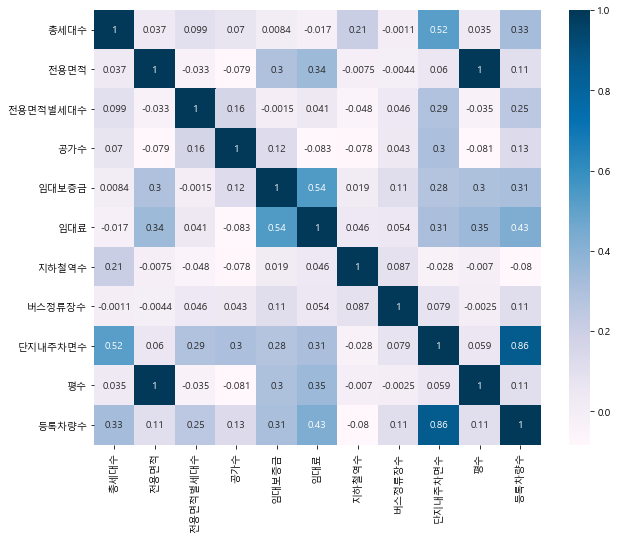

In [102]:
plt.figure(figsize = (10, 8))
sns.heatmap(train.corr(), annot=True, cmap=plt.cm.PuBu, linecolor='white');

## 로그변환

### 연속형 변수: 전용면적, 임대보증금, 임대료  
#### 구간을 나눠서 재범주화하거나 로그변환

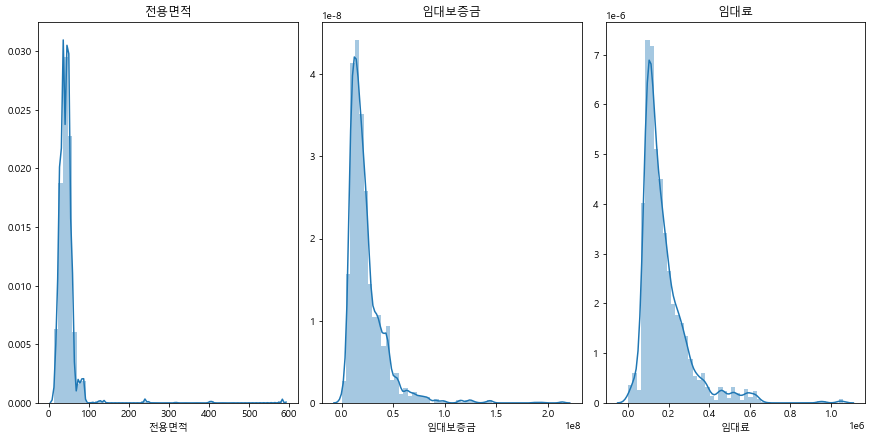

In [103]:
train_num = ['전용면적', '임대보증금', '임대료']
f, ax = plt.subplots(1, 3, figsize=(12,6), constrained_layout=True)
k = [0, 1, 2]
for i, k in zip(train_num, k):
    sns.distplot(train[i], ax = ax[k])
    ax[k].title.set_text(i)
    plt.rc('font', family = 'Malgun Gothic')
    plt.rc('axes', unicode_minus = False)

### 이산형 변수: 나머지 전체
#### 과도하게 세밀하게 나뉜 변수는 재범주화해도 될 듯

In [104]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '지하철역수', '버스정류장수', '단지내주차면수', '평수', '공급유형', '등록차량수'],
      dtype='object')

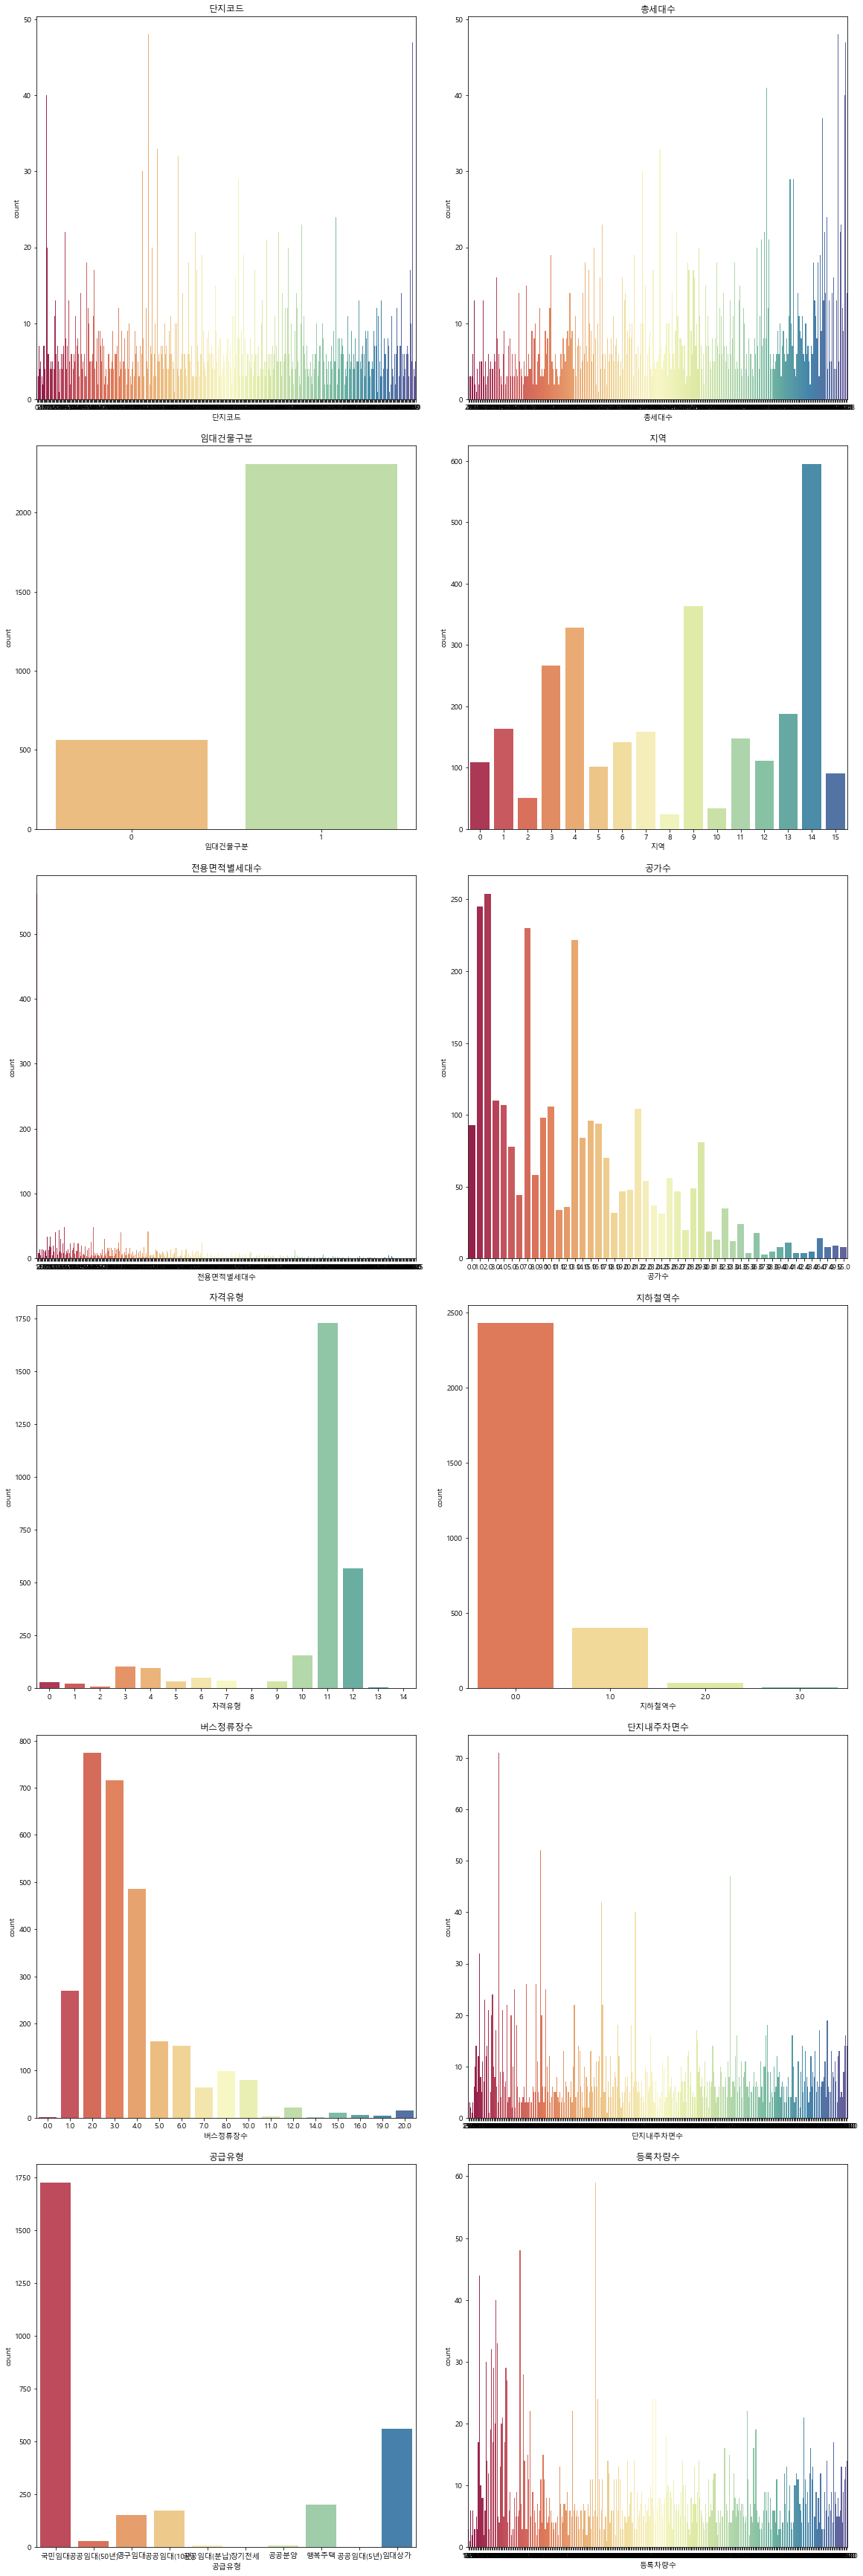

In [105]:
train_num = ['단지코드', '총세대수', '임대건물구분', '지역', '전용면적별세대수', '공가수', '자격유형',
           '지하철역수', '버스정류장수', '단지내주차면수', '공급유형', '등록차량수']
f, ax = plt.subplots(6, 2, figsize=(16,48), constrained_layout=True)
j = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
k = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
for i, j, k in zip(train_num, j, k):
    sns.countplot(train[i], ax = ax[j,k], palette="Spectral")
    ax[j, k].title.set_text(i)
    plt.rc('font', family = 'Malgun Gothic')
    plt.rc('axes', unicode_minus = False)

---

In [106]:
# # 데이터 중복확인
# train.shape, train.drop_duplicates().shape

In [107]:
# train = train.drop_duplicates()

---

## 지하철 결측치 위도/경도확인 

In [108]:
# #아파트/상가 데이터 나누기 (위에서 결측치채우기전에)
# df_ap=df[df['임대건물구분']=='아파트']
# df_bd=df[df['임대건물구분']=='상가']

In [109]:
#결측치확인
print(df_ap.isnull().sum()) #아파트
print('-------------------------------------------------------------')
print(df_bd.isnull().sum()) #상가

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
자격유형         0
임대보증금        0
임대료          0
지하철역수       80
버스정류장수       0
단지내주차면수      0
등록차량수        0
평수           0
dtype: int64
-------------------------------------------------------------
단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       562
임대료         562
지하철역수       127
버스정류장수        0
단지내주차면수       0
등록차량수         0
평수            0
dtype: int64


In [110]:
#충청남도 임대주택 위도/경도 데이터
cn_st=pd.read_csv('충남역.csv')
cn_hm=pd.read_csv('충남임대주택.csv')

In [111]:
# !pip install folium

In [114]:
import folium as g

In [115]:
g_map=g.Map(location=[36.915760,127.127057],zoom_start=13) #처음지도시작

In [116]:
#역표시하기
for i in range(len(cn_st)):
    marker01=g.CircleMarker([cn_st.loc[i]['위도'],cn_st.loc[i]['경도']],
                           radius=50,
                           color='skyblue',
                           fill_color='sky_blue')
    marker01.add_to(g_map)

In [117]:
#임대주택 표시하기
for j in range(len(cn_hm)):
    marker02=g.Marker([cn_hm.loc[j]['위도'],cn_hm.loc[j]['경도']],
                     icon=g.Icon(color='blue'),
                     popup=cn_hm.loc[j]['아파트명'])
    marker02.add_to(g_map)

In [118]:
g_map

In [120]:
df1=df_ap[df_ap['지역']=='충청남도']
df1[df1['지하철역수'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
86,C1312,518,아파트,충청남도,국민임대,39.72,60,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0,21.0
87,C1312,518,아파트,충청남도,국민임대,39.98,89,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0,21.0
88,C1312,518,아파트,충청남도,국민임대,41.55,225,12.0,A,19954000.0,130940.0,NaN,3.0,527.0,359.0,22.0
89,C1312,518,아파트,충청남도,국민임대,46.90,143,12.0,A,28687000.0,149660.0,NaN,3.0,527.0,359.0,23.0
90,C1874,619,아파트,충청남도,영구임대,26.37,294,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0,17.0
91,C1874,619,아파트,충청남도,영구임대,26.37,149,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0,17.0
92,C1874,619,아파트,충청남도,영구임대,31.32,149,2.0,C,3731000.0,83020.0,NaN,2.0,97.0,62.0,18.0
339,C1068,806,아파트,충청남도,국민임대,36.65,200,11.0,A,11234000.0,106090.0,NaN,2.0,804.0,510.0,20.0
340,C1068,806,아파트,충청남도,국민임대,36.98,130,11.0,A,11234000.0,106090.0,NaN,2.0,804.0,510.0,20.0
341,C1068,806,아파트,충청남도,국민임대,41.55,252,11.0,A,14981000.0,124830.0,NaN,2.0,804.0,510.0,22.0


In [123]:
#대전 역 데이터
df_dj=pd.read_csv('대전광역시역.csv')
df_djap=pd.read_csv('대전아파트.csv')

In [124]:
g_map2=g.Map(location=[36.392314,127.314609],zoom_start=13) #처음지도시작

#역표시하기
for k in range(len(df_dj)):
    marker01=g.CircleMarker([df_dj.loc[k]['위도'],df_dj.loc[k]['경도']],
                           radius=50,
                           color='skyblue',
                           fill_color='sky_blue')
    marker01.add_to(g_map2)

    
#임대주택 표시하기
for z in range(len(df_djap)):
    marker02=g.Marker([df_djap.loc[z]['위도'],df_djap.loc[z]['경도']],
                     icon=g.Icon(color='blue'),
                     popup=df_djap.loc[z]['아파트명'])
    marker02.add_to(g_map2)

In [125]:
g_map2

In [122]:
df2=df_ap[df_ap['지역']=='대전광역시']
df2[df2['지하철역수'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,평수
136,C1424,625,아파트,대전광역시,공공임대(50년),39.99,268,2.0,A,14247000.0,198980.0,NaN,7.0,517.0,179.0,21.0
137,C1424,625,아파트,대전광역시,공공임대(50년),49.95,119,2.0,A,20173000.0,225100.0,NaN,7.0,517.0,179.0,24.0
138,C1424,625,아파트,대전광역시,공공임대(50년),49.95,237,2.0,A,21203000.0,225100.0,NaN,7.0,517.0,179.0,24.0
139,C2100,880,아파트,대전광역시,국민임대,51.51,46,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0,25.0
140,C2100,880,아파트,대전광역시,국민임대,51.59,35,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0,25.0
141,C2100,880,아파트,대전광역시,국민임대,51.90,589,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0,25.0
142,C2100,880,아파트,대전광역시,국민임대,59.91,118,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0,27.0
143,C2100,880,아파트,대전광역시,국민임대,59.94,46,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0,27.0
144,C2100,880,아파트,대전광역시,국민임대,59.99,46,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0,27.0
163,C2520,970,아파트,대전광역시,공공임대(50년),39.69,960,2.0,A,13155000.0,177500.0,NaN,2.0,420.0,386.0,21.0


In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   전용면적      2869 non-null   float64
 5   전용면적별세대수  2869 non-null   int64  
 6   공가수       2869 non-null   float64
 7   자격유형      2869 non-null   object 
 8   임대보증금     2869 non-null   float64
 9   임대료       2869 non-null   float64
 10  지하철역수     2869 non-null   float64
 11  버스정류장수    2869 non-null   float64
 12  단지내주차면수   2869 non-null   float64
 13  평수        2869 non-null   float64
 14  공급유형      2869 non-null   object 
 15  등록차량수     2869 non-null   float64
dtypes: float64(9), int64(2), object(5)
memory usage: 358.8+ KB


In [128]:
age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지역         16 non-null     object 
 1   10대미만(여자)  16 non-null     float64
 2   10대미만(남자)  16 non-null     float64
 3   10대(여자)    16 non-null     float64
 4   10대(남자)    16 non-null     float64
 5   20대(여자)    16 non-null     float64
 6   20대(남자)    16 non-null     float64
 7   30대(여자)    16 non-null     float64
 8   30대(남자)    16 non-null     float64
 9   40대(여자)    16 non-null     float64
 10  40대(남자)    16 non-null     float64
 11  50대(여자)    16 non-null     float64
 12  50대(남자)    16 non-null     float64
 13  60대(여자)    16 non-null     float64
 14  60대(남자)    16 non-null     float64
 15  70대(여자)    16 non-null     float64
 16  70대(남자)    16 non-null     float64
 17  80대(여자)    16 non-null     float64
 18  80대(남자)    16 non-null     float64
 19  90대(여자)    16 non-null     float64
 20  90대(남자)    1